> ## Trabalho final ECM307
> ## Rafael Rubio 20.00611-0

In [13]:
import math 
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from control import TransferFunction
import scipy.io.wavfile as wav
import sounddevice as sd
import IPython.display as ipd
from IPython.display import Audio


REPETIÇÕES =15



# Requerimentos do trabalho:
1. Indicar as formantes encontradas para cada vogal.
2. Indicar a frequência fundamental de cada vogal.
3. Encontrar a função de Laplace para um trecho de uma determinada vogal    
4. Sintetizar a vogal no mesmo tempo da vogal original
5. Montar a segquência sintetizada A U A.

# Funções importantes do trabalho:

## Plota um grafico

In [14]:

def plotar_grafico(dado_x, dado_y, titulo, labelg="None", type="", label_x='Tempo em segundos', label_y='Amplitude'):
    plt.figure()
    plt.plot(dado_x, dado_y, type, label=labelg)
    plt.title(titulo)
    plt.legend()
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return plt


## Extrai informações da vogal: 
Pontos, período da amostragem, tempo total, vetor de tempo e o valor maximo

In [15]:

def extrai_vogal(fs, Vg, nome_vogal):
    N = len(Vg) # numero de pontos na vogal
    T1 = 1/fs # periodo de amostragem
    Ttot = (N-1)*T1 #tempo total da vogal
    Tvg= np.linspace(0, N*T1, N) # vetor tempo da vogal
    Pico = max(Vg)

    return N, T1, Tvg, Pico, Ttot



## Faz o ponderamento da vogal

In [16]:
def ponderar_vogal(N, Vg):
    Jh = np.hamming(N) # janela de hamming
    Vg_p = Vg*Jh # ponderando a vogal
    return Vg_p

## Calcula a

In [17]:


#def calcula_fourier

def calcular_laplace(b, c, amp):
    return TransferFunction([amp], [b, c])




## Vizualizando as vogais

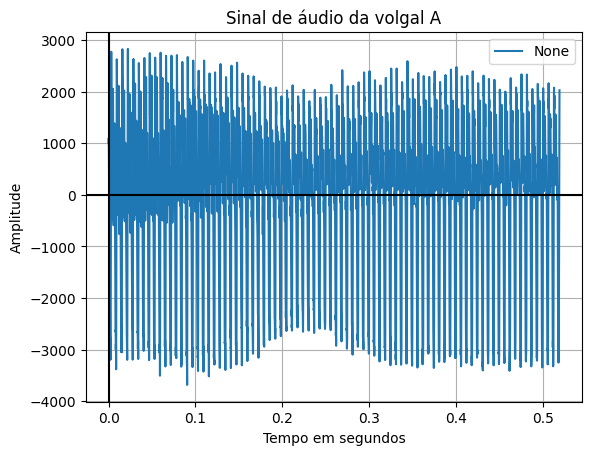

In [18]:
#Vogal A
fs_a, Vg_a = wav.read('2 - Fourier_Vogais_e.wav')
Na, T1a, Tvga, Pico_a, Ttot_a = extrai_vogal(fs_a, Vg_a, 'A')
plotar_grafico(Tvga, Vg_a, 'Sinal de áudio da volgal A', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_a, rate=fs_a)


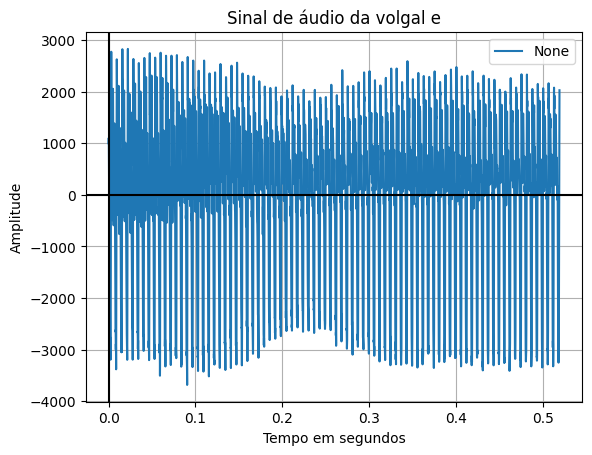

In [19]:
#Vogal E
fs_e, Vg_e = wav.read('2 - Fourier_Vogais_e.wav')
Ne, T1e, Tvge, Pico_e , Ttot_e = extrai_vogal(fs_e, Vg_e, 'E')
plotar_grafico(Tvge, Vg_e, 'Sinal de áudio da volgal e', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_e, rate=fs_e)

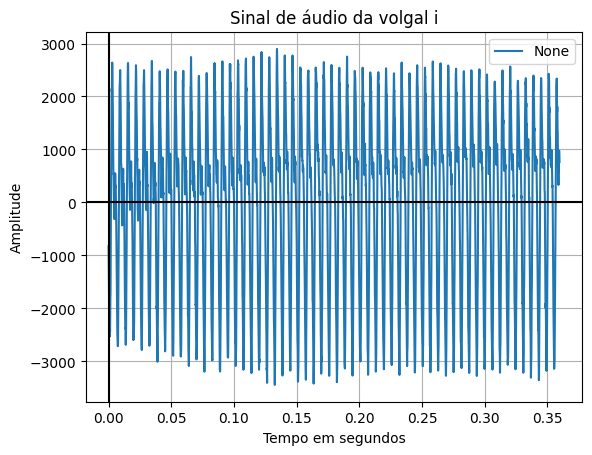

In [20]:
#Vogal I
fs_i, Vg_i = wav.read('2 - Fourier_Vogais_i.wav')
Ni, T1i, Tvgi, Pico_i, Ttot_i = extrai_vogal(fs_i, Vg_i, 'I')
plotar_grafico(Tvgi, Vg_i, 'Sinal de áudio da volgal i', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_i, rate=fs_i)

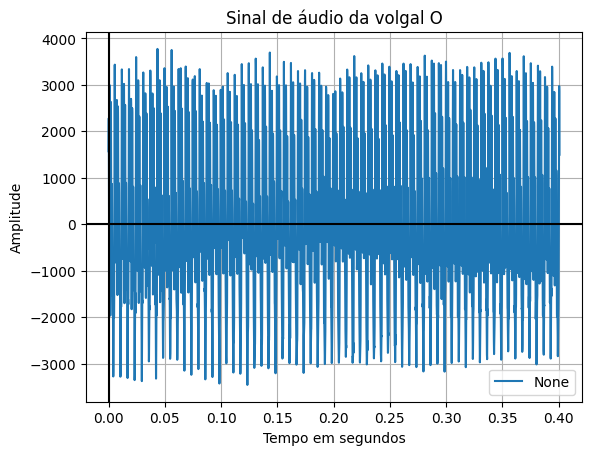

In [21]:
#Vogal O
fs_o, Vg_o = wav.read('2 - Fourier_Vogais_o.wav')
No, T1o, Tvgo, Pico_o, Ttot_o = extrai_vogal(fs_o, Vg_o, 'O')
plotar_grafico(Tvgo, Vg_o, 'Sinal de áudio da volgal O', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_o, rate=fs_o)

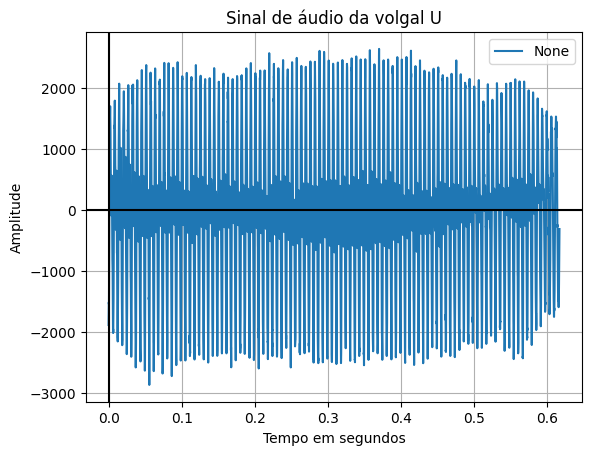

In [22]:
#Vogal U
fs_u, Vg_u = wav.read('2 - Fourier_Vogais_u.wav')
Nu, T1u, Tvgu, Pico_u, Ttot_u = extrai_vogal(fs_u, Vg_u, 'U')
plotar_grafico(Tvgu, Vg_u, 'Sinal de áudio da volgal U', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_u, rate=fs_u)

## Ponderando as vogais

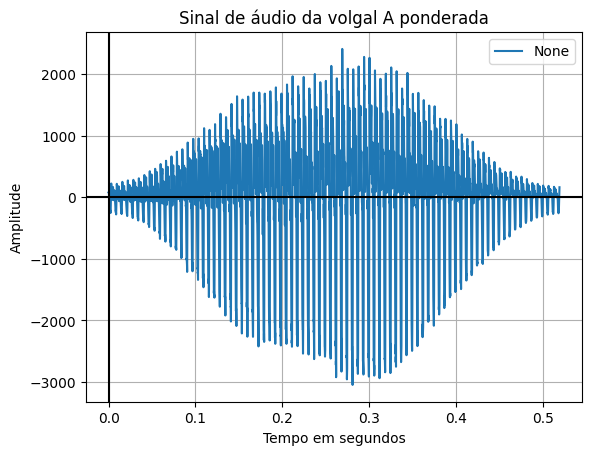

In [23]:
#Vogal A ponderada
Vg_ap = ponderar_vogal(Na, Vg_a)
plotar_grafico(Tvga, Vg_ap, 'Sinal de áudio da volgal A ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal E ponderada
Vg_ep = ponderar_vogal(Ne, Vg_e)
plotar_grafico(Tvge, Vg_ep, 'Sinal de áudio da volgal E ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal I ponderada
Vg_ip = ponderar_vogal(Ni, Vg_i)
plotar_grafico(Tvgi, Vg_ip, 'Sinal de áudio da volgal I ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal O ponderada
Vg_op = ponderar_vogal(No, Vg_o)
plotar_grafico(Tvgo, Vg_op, 'Sinal de áudio da volgal O ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal U ponderada
Vg_up = ponderar_vogal(Nu, Vg_u)
plotar_grafico(Tvgu, Vg_up, 'Sinal de áudio da volgal U ponderada', label_x='Tempo em segundos', label_y='Amplitude')

# 2. Encontrar a frequência fundamental de cada vogal


## Vogal A

Frequência fundamental da vogal i: 158.00Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

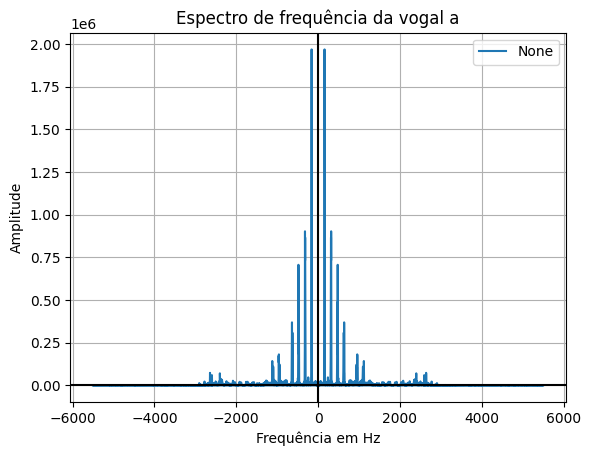

In [24]:
Fourier_a = np.fft.fft(Vg_ap) #transformada de fourier
freq_a = np.fft.fftfreq(Na, T1a) #vetor de frequencia
frequencia_fund_vga = abs(freq_a[np.where(abs(Fourier_a) == max(abs(Fourier_a)))]) #frequencia fundamental da vogal a
print(f'Frequência fundamental da vogal i: {frequencia_fund_vga[0]:,.2f}Hz')
plotar_grafico(freq_a, abs(Fourier_a), 'Espectro de frequência da vogal a', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal E

Frequência fundamental da vogal i: 158.00Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

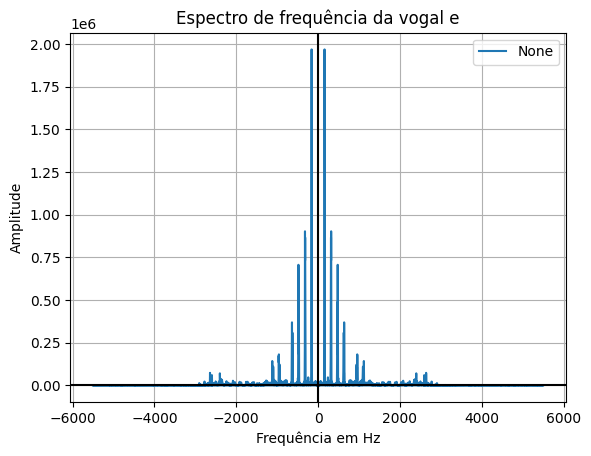

In [25]:
Fourier_e = np.fft.fft(Vg_ep) #transformada de fourier
freq_e = np.fft.fftfreq(Ne, T1e) #vetor de frequencia
frequencia_fund_vge = abs(freq_e[np.where(abs(Fourier_e) == max(abs(Fourier_e)))]) #frequencia fundamental da vogal e
print(f'Frequência fundamental da vogal i: {frequencia_fund_vge[0]:,.2f}Hz')
plotar_grafico(freq_e, abs(Fourier_e), 'Espectro de frequência da vogal e', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal I


Frequência fundamental da vogal i: 161.23Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

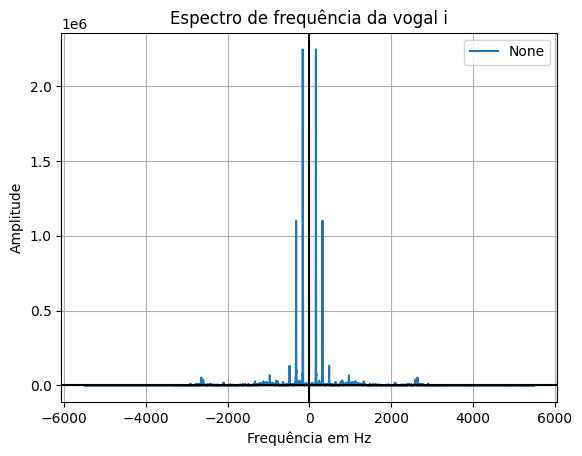

In [26]:
Fourier_i = np.fft.fft(Vg_ip) #transformada de fourier
freq_i = np.fft.fftfreq(Ni, T1i) #vetor de frequencia
frequencia_fund_vgi = abs(freq_i[np.where(abs(Fourier_i) == max(abs(Fourier_i)))]) #frequencia fundamental da vogal i
print(f'Frequência fundamental da vogal i: {frequencia_fund_vgi[0]:,.2f}Hz')
plotar_grafico(freq_i, abs(Fourier_i), 'Espectro de frequência da vogal i', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal O

Frequência fundamental da vogal o: 159.67Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

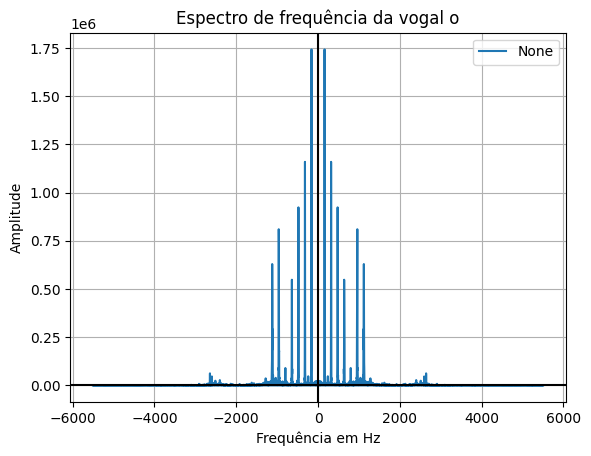

In [27]:
Fourier_o = np.fft.fft(Vg_op) #transformada de fourier
freq_o = np.fft.fftfreq(No, T1o) #vetor de frequencia
frequencia_fund_vgo = abs(freq_o[np.where(abs(Fourier_o) == max(abs(Fourier_o)))]) #frequencia fundamental da vogal o
print(f'Frequência fundamental da vogal o: {frequencia_fund_vgo[0]:,.2f}Hz')
plotar_grafico(freq_o, abs(Fourier_o), 'Espectro de frequência da vogal o', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal U

Frequência fundamental da vogal u: 160.53Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

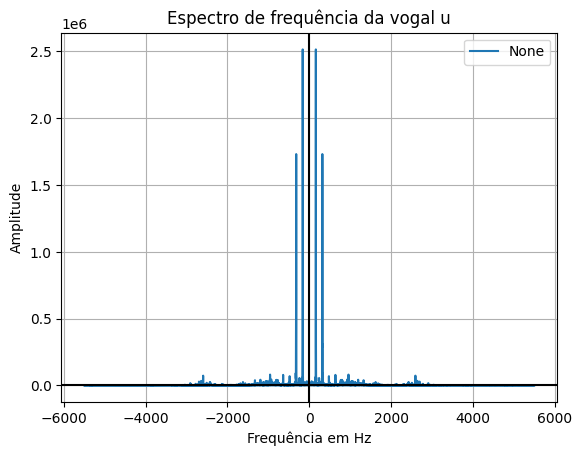

In [28]:
Fourier_u = np.fft.fft(Vg_up) #transformada de fourier
freq_u = np.fft.fftfreq(Nu, T1u) #vetor de frequencia
frequencia_fund_vgu = abs(freq_u[np.where(abs(Fourier_u) == max(abs(Fourier_u)))]) #frequencia fundamental da vogal u
print(f'Frequência fundamental da vogal u: {frequencia_fund_vgu[0]:,.2f}Hz')
plotar_grafico(freq_u, abs(Fourier_u), 'Espectro de frequência da vogal u', label_x='Frequência em Hz', label_y='Amplitude')

# 3. Encontrar a função de Laplace para um trecho de uma determinada vogal 